
# Tutorial 1: Creating and Solving Factor Graphs

In this tutorial you will learn how to create, solve, and explore factor graphs, as well as what variables, factors, and priors are.

**API Version: NavAbilitySDK.jl**

## Application of this Tutorial

These tutorials apply broadly to "robotics", and it is worth noting that we define 'robotics' to include 
- **Infrastructure Management: Digitize** construction, manufacturing, warehousing operations into real-time virtual assets
- Warehouse **Automation**: Orchestrating interactions between pickers and AGVs in a warehouse
- Enhanced **metrology and calibration** equipment.
- Environment **mapping and survey** equipment, including cell phone survey, robotic surveyor Total Station.
- **Inspection and monitoring** robots building a map (factory, warehouses, subsea infrastructure, etc.)
- And many more.

### Vision: Interacting Robotics

Zooming in further, let's consider a factory environment where various interacting robotic equipment are producing and transporting objects -- i.e. manufacturing and logistics support.  The figure below conceptually shows how a product winds it's way from the factory floor, through various robotic handovers, and out via shipping on a truck.  Each robot individually needs a geometrical (and later semantic) understanding of the task object, their location, the surroundings, and of other agents.  Each robot therefore will have it's own navigation solution.

Longer term, these navigation solutions will need to interact.  The figure below shows at the highest level how factor graphs provide a technique / method / roadmap on how to develop more intelligent robotic equipment that can calibrate, localize, map, track, interact, or cooperate:

![Why Factor Graphs](https://github.com/NavAbility/BinderNotebooks/raw/main/static/icra-1/why-factorgraphs.png)

This tutorial starts the conversation on how to overcome the **crux navigation AI software challenge**, and applies to both individual and interacting robotic systems.  This tutorial is the first step in showing how the idea of factor graphs can provide a good engineering balance in flexibility, ease of use, and mathematical foundation.  

This tutorial will show some of the most basic operations that you can perform with factor graphs, and further tutorials will fill in more and more of the features and capabilities.  Keep in mind that this and several more tutorials must be brought together for the necessary feature set to deploy multi-agent environments of interacting humans and robots.

### Let's build a factor graph

First, we will need some packages: 
- `NavAbilitySDK` - Access NavAbility Cloud factor graph features from Julia.
- `LinearAlgebra` and `UUIDs` - Standard Julia libraries that will be useful.

## What is a Factor Graph

Calibration / localization / tracking / mapping / perception problems in robotics can be solved very effectively with factor graphs, which provide a common language to describe the underlying estimation problem from available data; and in a way both humans and computers can easily understand.   A factor graph is a graphical modelling language with two types of nodes, namely variables and factors, which are connected by edges according to how they interact.  This sketch illustrates a simple example with variables, the large circular nodes, and factors, the square nodes -- note, the interactive code segments below will explain how graphs this like are constructed and why:

![Tut1 Graph Sketch](https://github.com/NavAbility/BinderNotebooks/raw/main/static/icra-1/example-fg.png)

Variables represent unknown states that the user wants the computer to estimate, such as the position or orientation of some equipment, or position of landmarks in the environment, or maybe hidden calibration parameters that are difficult to measure directly, and potetially many, many more.

Factors usually represent the interaction between sparse variables based on some measurement data, e.g. the distance from one point to another -- i.e. a range factor.
This is where basic math and measurement functions are included and used during computation.
For example, encoder measurements from wheels, ranges from a laser, or tag readings from a camera.
The variables associated with each data cue / measurement is depicted by the edges eminating from each factor.
Our solution aleady provides a library of standard variables and factors that require zero mathematical input from the user, yet the technology rapidly supports building of new variables and factors, potentially containing exotic computations -- more on that later.

From a technical perspective, factor graphs allow for an **apples and apples** framework where different sensor measurements / data cues can be combined and jointly processed according to their indivual statistical properties.  Factor graphs allow the system developer to think about each measurement on their own, rather than having to deal with the challenging data fusion problem manually.  This **greatly simplifies the problem**, since the rigorous computational aspects are dealt with by factor graph solver and associated algorithms.

Later tutorials will show how to handle low confidence, ambiguous, and 'strange' measurement scenarios.  **This is an interactive tutorial, so let's dive in and navigate a robot!**

> For additional info, see the Caesar.jl docs on [Graph Concepts](https://juliarobotics.org/Caesar.jl/latest/concepts/concepts/#Graph-Concepts) and beyond, for more details on graph factorization, elimination, recycling, federated solutions, data handling, serialization and much more.


### Let's build a factor graph

First, we will need some packages: 
- `NavAbilitySDK` - Access NavAbility Cloud factor graph features from Julia.

Your environment should already have these packages installed, so you can immediate try the `using` code cells below.

> But just in case your environment does not have the packages installed, the `Pkg.add` code cell is provided just in case.  There is no harm in running the install more than once, it might just take a bit more time.

In [ ]:
# install packages in case they are not installed
import Pkg; Pkg.add("NavAbilitySDK");

In [ ]:
using NavAbilitySDK

## Build a factor graph

The first thing to do is setup a client-context to talk with the NavAbility Platform:

In [ ]:
# you need a unique userId:robotId, and can keep using that across all tutorials
userId = "guest@navability.io"
robotId = "SDKjl_"*(string(uuid4())[1:4])

# also create a client connection
client = NavAbilityHttpsClient()

In [ ]:
# You'll need a unique session number each time you run a new graph
sessionId = "Tutorial1_"*(string(uuid4())[1:4])
# context is the object to use below
context = Client(userId,robotId,sessionId)

## Variables and Factors 

Variables represent state variables of interest such as vehicle or landmark positions, sensor calibration parameters, and more. Variables are likely hidden values that are not directly observed, but we want to estimate them from observed data and at least some minimal algebra structure from probabilistic measurement models.

Factors represent the interaction between particular variables, as captured measurement or data cues.  
For example, a distance travelled measurement between two pose variables.  Relative factors between variables are probabilistic models that capture the likelihood interactions between variables.  Priors factors (i.e. unary to one variable) represent absolute information to be introduced about that variable, for example a GPS measurement; more on how to introduce distrust of such priors later.

`NavAbilitySDK.jl` provides variables and factors useful to robotics.
We start with a `Pose2` variable, i.e. position and orientation in two dimensions.
Call `addVariable` with a label `x0` and type `Pose2` to add variables to the factor graph

In [ ]:
# let's collect all the async responses and wait at the end
resultIds = Task[]
# addVariable and keep the transaction ID
push!(resultIds, 
  addVariable(client, context, Variable("x0", :Pose2))
);

We now have a factor graph with one variable, but to solve it we need some additional information. 
In this example, we need the estimated starting point of our robot.
We use unary factors called priors to represent absolute information to be introduced. 
In this case we use `PriorPose2`, as our variable type is also `Pose2`.
Since factors represent a probabilistic interaction between variables, we need to specify the distribution our factor will represent. Here we use `FullNormal` which is a [multivariate normal distribution](https://en.wikipedia.org/wiki/Multivariate_normal_distribution). 

Let's create a `PriorPose2` unary factor with zero mean and a covariance matrix of (`diagm([0.05,0.05,0.01].^2)`):

$\Sigma = \begin{bmatrix} 0.0025 & 0.0 &  0.0 \\ 0.0 & 0.0025 & 0.0 \\ 0.0 &  0.0 &  0.0001 \end{bmatrix}$

In [ ]:
f = Factor("x0f1", "PriorPose2", ["x0"], 
PriorPose2Data(
  Z=FullNormal(
    [0.0, 0.0, 0.0], 
    diagm([0.05, 0.05, 0.01].^2))))

push!(resultIds, addFactor(client, context, f));

In [ ]:
# let's wait to make sure all nodes were added
waitForCompletion(client, resultIds; expectedStatuses=["Complete"])

We can look at the factor graph we have so far using the generated link to the NavAbilityApp, and note the variable node `x0` and prior factor node `x0f1`.  Click on the generated graphic to open the NavAbility App visualization:

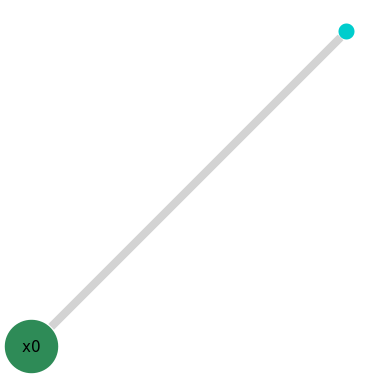

In [2]:
# Click on the generated factor graph graphic to open NavAbility App visualization
GraphVizApp(context)

The prior is now connected to the variable, `x0`, but it is not initialized yet. Automatic initialization of variables depends on how the factor graph model is constructed. So far, `x0` has not been initialized.

**Graph-based Initialization**

At this stage `x0` is not initialized, since no numerical solution has yet been computed.  We do this as the future intentions of the user are unknown and the initialization of `x0` is deferred until the latest possible moment.  The NavAbility Platform assumes that the new variables and factors can be initialized when they are solved for the first time.

By delaying initialization of a new variable (say `x0`) until a second newer uninitialized variable (say `x1`) that depends on `x0`, the `Caesar.jl` algorithms can initialize `x0` with more information from surrounding variables and factors.  Solving over the entire graph will set the numerical values. 

**Robot Odometry - Relative Factor**

Next, we want to add an odometry factor that connects our two robot poses `x0` and `x1` together to form a chain.
Here we use a relative factor of type `Pose2Pose2` with a measurement from pose `x0` to `x1` of (x=1.0,y=0.0,θ=pi/2); the robot drove 1 unit forward (in the x direction).
Similarly to the prior we added above, we use a `FullNormal` distribution to represent the odometry with mean and covariance:

$\mu =(x=1, y=0, \theta=\frac{\pi}{2})$

$\Sigma = \begin{bmatrix} 0.01 & 0.0 &  0.0 \\ 0.0 & 0.01 & 0.0 \\ 0.0 &  0.0 &  0.0001 \end{bmatrix}$


In [ ]:
# add x1
push!(resultIds, 
  addVariable(client, context, Variable("x1", :Pose2))
)

# add odometry measurement between x0 and x1
f = Factor("x0x1f1", "Pose2Pose2", ["x0","x1"], 
  Pose2Pose2Data(
    Z=FullNormal(
      [1.0, 0.0, pi/2], 
      diagm([0.1, 0.1, 0.01].^2))
  )
)
push!(resultIds, addFactor(client, context, f));

Let's look at the factor graph again

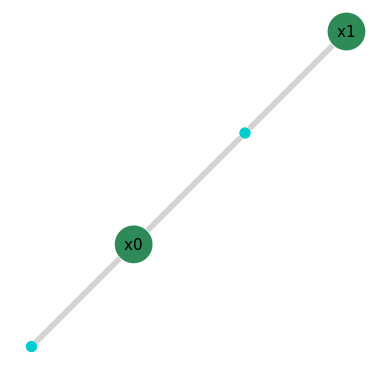

In [3]:
# Click on the generated factor graph graphic to open NavAbility App visualization
GraphVizApp(context)

The structure of the graph has now been updated to two variable nodes and two factors.

## Solving

We now have a graph we can solve using the Multi-Modal iSAM (MM-iSAM) algorithm. 
The default solver will perform non-parametric inference/state-estimation over our newly created graph.

Fundamentally, inference is performed via the Bayes (junction) tree where Chapman-Kolmogorov transit integral solutions are based on marginal-joint belief estimation (a sum-product / belief-propagation approximation algorithm). Many benefits such as clique recycling are also available. See the [Solving Graphs](https://juliarobotics.org/Caesar.jl/latest/concepts/solving_graphs/) section in the documentation for more detail.

In [ ]:
push!(resultIds,
  solveSession(client, context)
);

# Give it a few seconds JIT compiling during first run.
println("running solve...")

A _slightly_ more the mathy explination.  A factor graph represents the factorization of the overall joint probability belief function that describes your system.
It represents a breakdown of the complex problem describing your robot navigation, and does so in a way that a computer can work through in a very efficient manner. 
This factorization allows us to solve the optimization (a.k.a. inference) problem for all variables given every measurement described by the factors.

### Multi-Sensor Data Fusion

In our example so far, the graph models the position and orientation (pose) of your robot at any given time, and soon we will add relative measurements to landmarks using a different sensor but captured in the same factor graph. 

## Results

The NavAbility WebApp allows visualization of the belief state over any of the variables.  Also try with Belief and Distribution buttons to see more of the underlying posterior marginal belief estimates.  The results will show as the solve completes.

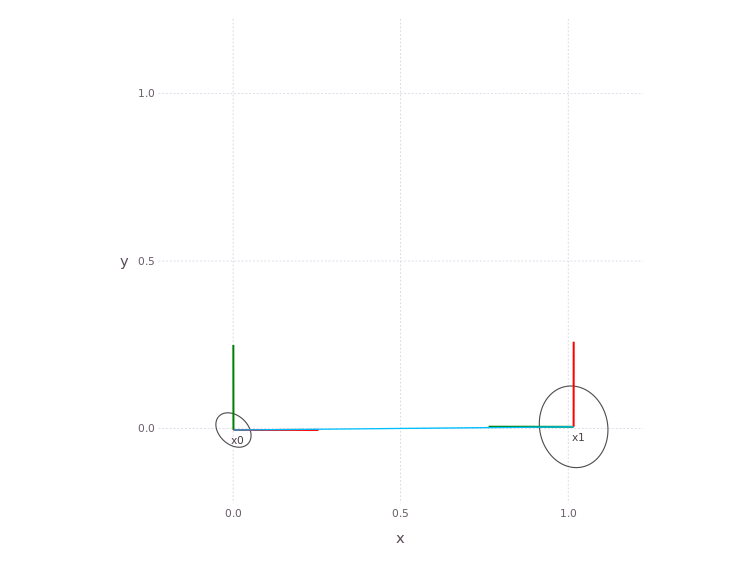

In [4]:
# Click on the generated factor graph graphic to open NavAbility App visualization
MapVizApp(context)

**What is happening**

The figure shows the position and orientation (red forward) for poses `x0` and `x1`. As well as the covariance ellipse. 
Since the solver used was non-parametric, the covariance ellipse is based on a best Gaussian distribution fit of the full belief.
A few other functions are also handy for interacting with the factor graph, for instance `getVariable` returns the full variable.


Or if you are interested in the suggested Parametric Point Estimate (PPE).

In [ ]:
vars = getVariables(client, context; detail=SUMMARY) |> fetch
lbls = vars .|> x->x["label"]
ppes = vars .|> x->float.(x["ppes"][1]["suggested"])

println.(lbls .=> ppes);

**Parametric point estimates and beliefs**

A PPE can be the maximum or mean of the belief. 
If the belief is a normal distribution, both correspond with its mean. 
However, care should be taken with using PPEs when beliefs might be non-parametric, for example, in a multimodal belief with two peaks, max corresponds with the maximum of the two peaks while the mean will fall somewhere in between them. 
In non-parametric cases, it is better to work with the full belief obtained by the Kernel Density Estimate (KDE).  
Kernel Density Estimation is a non-parametric way to estimate the probability density function of a random variable.
With the default solver, a full probability density function is always available and can be visualized as shown by the distribution plot feature in the NavAbility WebApp.
Non-parametric solutions will be discussed in more detail in tutorial 2.

More plotting options exist, depending on how you are accessing the data.  See the [section on Plotting in the Caesar docs](https://juliarobotics.org/Caesar.jl/latest/concepts/2d_plotting/) for additional detail.

## Adding a Landmark from a Different Sensor

So far we worked with the `Pose2` factor type. 
Among others, `NavAbilitySDK` also provides the `Point2` variable and `Pose2Point2BearingRange` factor types, which we will use to represent a landmark sighting in our factor graph.
We will add a landmark `l1` with bearing range measurement of bearing=$(\mu=0,\sigma=0.03)$ range=$(\mu=0.5,\sigma=0.1)$ and continue our robot trajectory by driving around in a square.

In [ ]:
# add one landmark
push!(resultIds,
  addVariable(client, context, Variable("l1", :Point2)))

# add three more poses
for x in ["x2"; "x3"; "x4"]
  push!(resultIds,
    addVariable(client, context, Variable(x, :Pose2)))
end

## add Factors
F = [
  # add landmark observation measurement and
  Factor("x0l1f1", "Pose2Point2BearingRange", ["x0","l1"], 
  Pose2Point2BearingRangeData(
    bearing = Normal(0, 0.03), 
    range = Normal(0.5, 0.1))),
    
  # odometry measurements between poses
  Factor("x1x2f1", "Pose2Pose2", ["x1","x2"], 
  Pose2Pose2Data(
    Z=FullNormal(
      [1.0, 0.0, pi/2], 
      diagm([0.1, 0.1, 0.01].^2))
  )),
  Factor("x2x3f1", "Pose2Pose2", ["x2","x3"], 
  Pose2Pose2Data(
    Z=FullNormal(
      [1.0, 0.0, pi/2], 
      diagm([0.1, 0.1, 0.01].^2))
  )),
  Factor("x3x4f1", "Pose2Pose2", ["x3","x4"], 
  Pose2Pose2Data(
    Z=FullNormal(
      [1.0, 0.0, pi/2], 
      diagm([0.1, 0.1, 0.01].^2))
  ))
]

[push!(resultIds, addFactor(client, context, f)) for f in F];

Let's go look at the factor graph now, again using the NavAbilityApp

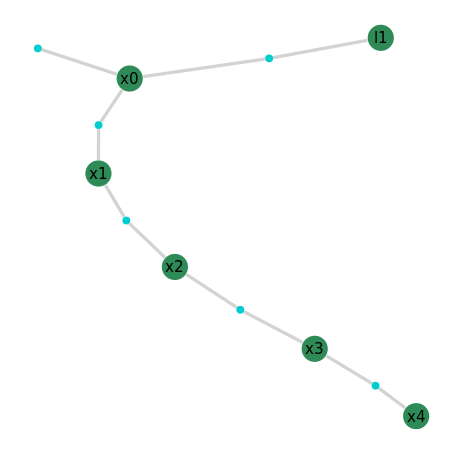

In [7]:
# Click on the generated factor graph graphic to open NavAbility App visualization
GraphVizApp(context)

We now have a longer odometry chain with one landmark sighting, let's solve the factor graph again so we can have a look at the results.

In [ ]:
# let's wait to make sure all the new additions are ready
waitForCompletion(client, resultIds; expectedStatuses=["Complete"], maxSeconds=180)
# then start a single solve
push!(resultIds,
  solveSession(client, context)
);
println("running solve...")

The solve will take a bit of time.  Just keep watching the geometric visualization, which will automatically update as more of the solution is published

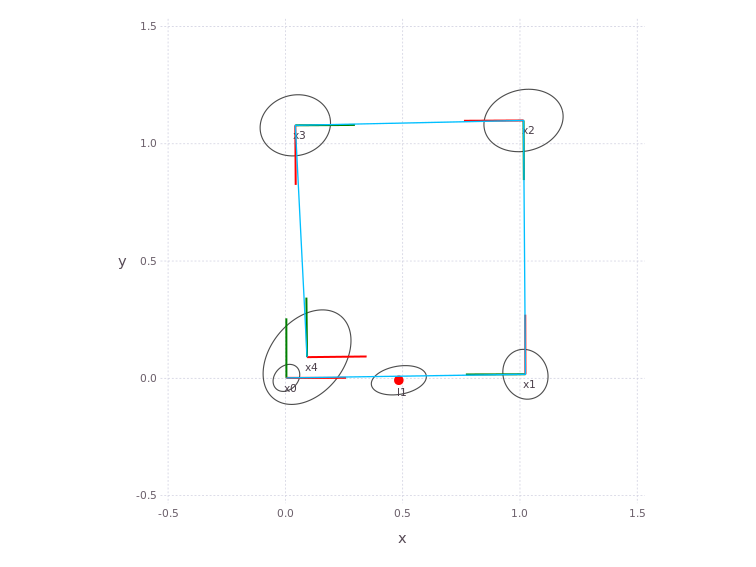

In [9]:
# Click on the generated factor graph graphic to open NavAbility App visualization
MapVizApp(context)

Once solving has completed, the variable results can be looked at in various ways.  Here we are just looking at the PPE values, but the full posterior marginal beliefs are available by simply asking for more results.

In [ ]:
vars = getVariables(client, context; detail=SUMMARY) |> fetch
lbls = vars .|> x->x["label"]
ppes = vars .|> x->float.(x["ppes"][1]["suggested"])

println.(lbls .=> ppes);

### Adding a Loop Closure

As expected, the robot continued its square trajectory to end off where it started. 
To illustrate a loop closure, we add another bearing range sighting to from pose `x4` to landmark `l1`, solve the graph and plot the new results: 

In [ ]:
# add a loop closure landmark observation
f = Factor("x4l1f1", "Pose2Point2BearingRange", ["x4","l1"], 
  Pose2Point2BearingRangeData(
    bearing = Normal(0, 0.03), 
    range = Normal(0.5, 0.1))
)
push!(resultIds, addFactor(client, context, f));
#

# let's wait to make sure all the new additions are ready
waitForCompletion(client, resultIds; expectedStatuses=["Complete"])

# then start a single solve
push!(resultIds,
  solveSession(client, context)
);
println("running solve...")

Let's go look at the final results again, which now includes the loop closure.  Use the 'Show Belief', 'Show Distribution' buttons along the bottom for more visual information.  You can also trigger new solves (as long as the Global Filter fields are properly set in the far right filter menu).

Use the NavAbilityApp hamburger menu on the left to navigate between the graph and geometric map visualization.  You can also use the Global Filter menu on the right to set which information to visualize.

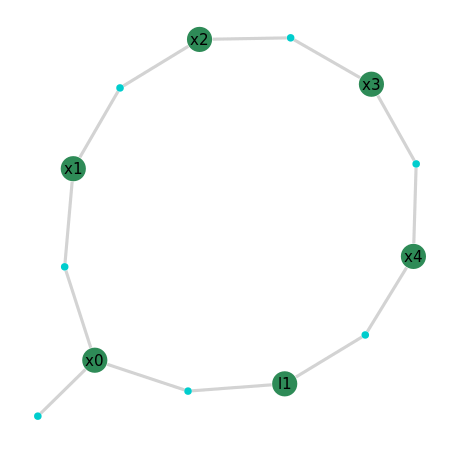

In [13]:
# Click on the generated factor graph graphic to open NavAbility App visualization
GraphVizApp(context)

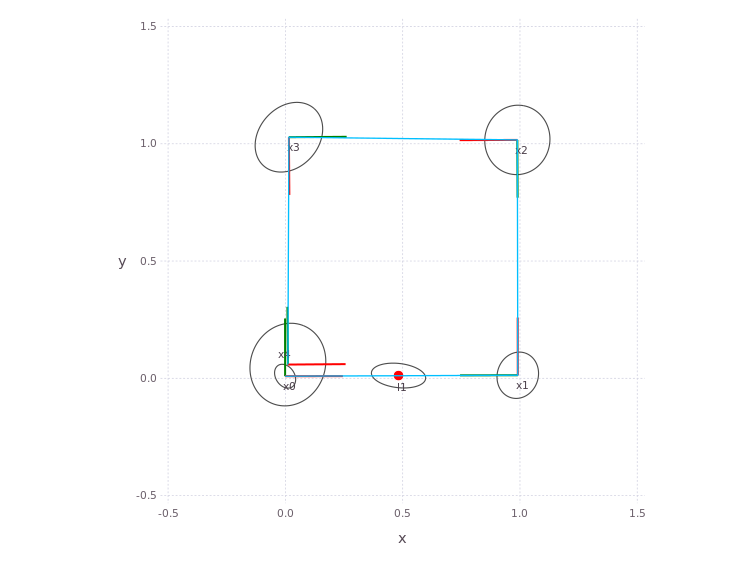

In [12]:
# Click on the generated factor graph graphic to open NavAbility App visualization
MapVizApp(context)

## Next Steps

Tutorial 2 will give an introduction to non-parametric solutions.

## Additional Resources

### Factors are On-Manifold

The variables used in this tutorial, `Point2` and `Pose2`, are represented as points on manifolds and all algebraic operations, inference/optimization are also performed on manifold.
For more information on how manifolds are used in Caesar.jl, refer to the [manifold section in the documentation](https://juliarobotics.org/Caesar.jl/latest/concepts/using_manifolds/).

### Custom Variables and Factors

In most scenarios, the existing variables and factors should be sufficient for most robotics applications. 
Caesar however, is extensible and allows you to easily incorporate your own variable and factor types for specialized applications.

Have a look at the Caesar documentation if you are interested in creating custom variables, factors (or priors)

- [Custom variables](https://juliarobotics.org/Caesar.jl/latest/examples/custom_variables/)
- [Custom prior factors](https://juliarobotics.org/Caesar.jl/latest/examples/basic_definingfactors/)
- [Custom relative factors](https://juliarobotics.org/Caesar.jl/latest/examples/custom_relative_factors/)


### Bayes (Junction) Tree

Inference is performed on the Bayes tree see: [Bayes tree principles](https://juliarobotics.org/Caesar.jl/latest/principles/bayestreePrinciples/)